In [30]:
import matplotlib.pyplot as plt
import numpy as np

import dataset_handler
from dataset_handler import *
import progressbar
from IR_analysis import dewarp_data, get_dewarp_parameters, sort_corner_points
from DataTypes import IrData
from datetime import datetime
import user_config as ucfg
from scipy.interpolate import RectBivariateSpline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
points = [(120,450),(370,460),(120,260),(370,263)]

In [7]:
data = IrData('data')
MEASUREMENT_NAME = 'test'

In [8]:
ucfg.get_path('saved_data')

H:\Users\mtw16\Documents\PyCharmProjects\IR-Reader\test\saved_data/


'H:\\Users\\mtw16\\Documents\\PyCharmProjects\\IR-Reader\\test\\saved_data/'

In [15]:
start, end = 0, len(data.data_numbers)
TARGET_RATIO = 1
selected_points = points
dewarp_params = get_dewarp_parameters(sort_corner_points(selected_points), target_ratio=TARGET_RATIO)

h5_file = create_h5_file(f'{MEASUREMENT_NAME}')
grp = h5_file['dewarped_data']
grp.attrs['transformation_matrix'] = dewarp_params['transformation_matrix']
grp.attrs['target_pixels_width'] = dewarp_params['target_pixels_width']
grp.attrs['target_pixels_height'] = dewarp_params['target_pixels_height']
grp.attrs['target_ratio'] = TARGET_RATIO
grp.attrs['selected_points'] = selected_points
grp.attrs['frame_range'] = (start, end)
grp.attrs['points_selection_date'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
dset_h,dset_w = dewarp_params['target_pixels_height'], dewarp_params['target_pixels_width']

dset = grp.create_dataset('data',
          (dset_h, dset_h, 1),
            maxshape=(dset_h, dset_w, None),
            chunks=(dset_h, dset_w, 1),

                   dtype=np.float32)

In [35]:
def dewarp_exp(exp_name, data, frequency = 10):
    dset = dataset_handler.get_file(exp_name, 'a')['dewarped_data']['data']
    metadata = dataset_handler.get_dewarped_metadata(exp_name)
    data_numbers = data.data_numbers
    dewarp_params = {}
    # grp.attrs['transformation_matrix'] = dewarp_params['transformation_matrix']
    # grp.attrs['target_pixels_width'] = dewarp_params['target_pixels_width']
    # grp.attrs['target_pixels_height'] = dewarp_params['target_pixels_height']
    # grp.attrs['target_ratio'] = TARGET_RATIO
    # grp.attrs['selected_points'] = selected_points
    # grp.attrs['frame_range'] = (start, end)
    start, end = metadata['frame_range']
    dset_w = metadata['target_pixels_width']
    dset_h = metadata['target_pixels_height']
    dewarp_params['transformation_matrix'] = metadata['transformation_matrix']
    dewarp_params['target_pixels_width'] = metadata['target_pixels_width']
    dewarp_params['target_pixels_height'] = metadata['target_pixels_height']
    dewarp_params['target_ratio'] = metadata['target_ratio']
    dewarp_params['selected_points'] = metadata['selected_points']
    dewarp_params['frame_range'] = metadata['frame_range']
    bar = progressbar.ProgressBar(max_value=end - start)
    for i, idx in bar(enumerate(data_numbers[start:end:frequency])):
        img = data.get_frame(idx)
        dewarped_data = dewarp_data(img, dewarp_params)
        dset.resize((dset_h, dset_w, i + 1))
        dset[:, :, i] = dewarped_data

    dataset_handler.close_file()
    
    
def dewarp_exp2(exp_name, data, frequency = 10):
    dset = dataset_handler.get_file(exp_name, 'a')['dewarped_data']['data']
    metadata = dataset_handler.get_dewarped_metadata(exp_name)
    data_numbers = data.data_numbers
    dewarp_params = {}
    # grp.attrs['transformation_matrix'] = dewarp_params['transformation_matrix']
    # grp.attrs['target_pixels_width'] = dewarp_params['target_pixels_width']
    # grp.attrs['target_pixels_height'] = dewarp_params['target_pixels_height']
    # grp.attrs['target_ratio'] = TARGET_RATIO
    # grp.attrs['selected_points'] = selected_points
    # grp.attrs['frame_range'] = (start, end)
    start, end = metadata['frame_range']
    dset_w = metadata['target_pixels_width']
    dset_h = metadata['target_pixels_height']
    dewarp_params['transformation_matrix'] = metadata['transformation_matrix']
    dewarp_params['target_pixels_width'] = metadata['target_pixels_width']
    dewarp_params['target_pixels_height'] = metadata['target_pixels_height']
    dewarp_params['target_ratio'] = metadata['target_ratio']
    dewarp_params['selected_points'] = metadata['selected_points']
    dewarp_params['frame_range'] = metadata['frame_range']
    
    map_x = np.arange(0, dset_w, 1)
    map_y = np.arange(0, dset_h, 1)

    transformation_matrix = dewarp_params['transformation_matrix']
    src_x = transformation_matrix[0,0]*map_x + transformation_matrix[0,1]*map_y + transformation_matrix[0,2]/(transformation_matrix[2,0]*map_x + transformation_matrix[2,1]*map_y + transformation_matrix[2,2])
    src_y = transformation_matrix[1,0]*map_x + transformation_matrix[1,1]*map_y + transformation_matrix[1,2]/(transformation_matrix[2,0]*map_x + transformation_matrix[2,1]*map_y + transformation_matrix[2,2])
    
    height, width = data.get_frame(data_numbers[0]).shape

    bar = progressbar.ProgressBar(max_value=end - start)
    for i, idx in bar(enumerate(data_numbers[start:end:frequency])):
        img = data.get_frame(idx)
        interp = RectBivariateSpline(np.arange(0, height, 1), np.arange(0,width, 1), img)
        dewarped_data = interp.ev(src_y, src_x)
        dset.resize((dset_h, dset_w, i + 1))
        dset[:, :, i] = dewarped_data

    dataset_handler.close_file()


In [33]:
%%time
dewarp_exp('test', data,1)

 98% (95 of 96) |####################### | Elapsed Time: 0:00:12 Time:  0:00:1201


CPU times: total: 9.7 s
Wall time: 12.3 s


In [36]:
%%time
dewarp_exp2('test', data,1)

 98% (95 of 96) |####################### | Elapsed Time: 0:00:15 Time:  0:00:1501


CPU times: total: 11.8 s
Wall time: 15.2 s


In [38]:
d1 = get_dewarped_data('test_old')[:]
d2 = get_dewarped_data('test')[:]

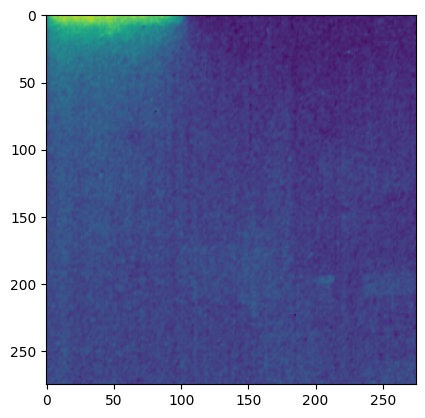

In [40]:
import matplotlib.pyplot as plt
plt.imshow(d1[:,:,0])

In [43]:
interp

NameError: name 'interp' is not defined

In [42]:
d2

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan